In [127]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data = '/content/gdrive/MyDrive/data'

Mounted at /content/gdrive


In [128]:
print(root_path)

/content/gdrive/MyDrive/data


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.metrics import confusion_matrix
import itertools
np.random.seed(2)

from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [130]:
X_train = np.load(data + "/train_pixels.npy")
y_train = np.load(data + "/train_labels.npy")
X_val =   np.load(data + "/eval_pixels.npy")
y_val =   np.load(data + "/eval_labels.npy")
X_test =  np.load(data + "/test_pixels.npy")
y_test =  np.load(data + "/test_labels.npy")

In [131]:
X_train = np.expand_dims(X_train, -1).astype("float32") / 255
X_val = np.expand_dims(X_val, -1).astype("float32") / 255
X_test = np.expand_dims(X_test, -1).astype("float32") / 255

In [132]:
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [133]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2))) 
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2))) 
  model.add(Dropout(0.5))

  model.add(Conv2D(256, (3,3), padding="Same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2))) 
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(7, activation='softmax'))

  # simple early stopping
  es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  optimizer = opt.Adam(lr = 0.001)
  lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [134]:
start = time.time()
model = define_model()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size = 100, callbacks=[es,lr_anneal])
end = time.time()
print('Elasped Time in minutes:  %.2f' % ((end - start)/60))

Epoch 1/50
288/288 [==============================] - 12s 39ms/step - loss: 2.3382 - accuracy: 0.3239 - val_loss: 1.5856 - val_accuracy: 0.3578
Epoch 2/50
288/288 [==============================] - 11s 39ms/step - loss: 1.2989 - accuracy: 0.5234 - val_loss: 1.1004 - val_accuracy: 0.6116
Epoch 3/50
288/288 [==============================] - 11s 39ms/step - loss: 1.0755 - accuracy: 0.6086 - val_loss: 0.9412 - val_accuracy: 0.6662
Epoch 4/50
288/288 [==============================] - 11s 39ms/step - loss: 0.9612 - accuracy: 0.6508 - val_loss: 0.8669 - val_accuracy: 0.6882
Epoch 5/50
288/288 [==============================] - 11s 39ms/step - loss: 0.8847 - accuracy: 0.6758 - val_loss: 0.8421 - val_accuracy: 0.6971
Epoch 6/50
288/288 [==============================] - 11s 38ms/step - loss: 0.8265 - accuracy: 0.7005 - val_loss: 0.7781 - val_accuracy: 0.7233
Epoch 7/50
288/288 [==============================] - 11s 38ms/step - loss: 0.8102 - accuracy: 0.7010 - val_loss: 0.8949 - val_accuracy:

# New Section

In [135]:
model.save(data +'/final_cnn_model.h5')
time.sleep(10)

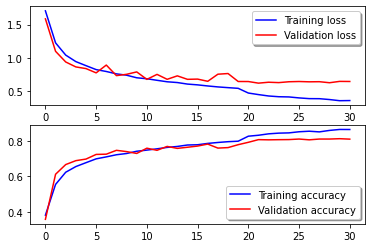

In [136]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [137]:
save_model = load_model(data+'/final_cnn_model.h5')

In [138]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    labels = "0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral"
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label \n\n' + labels)

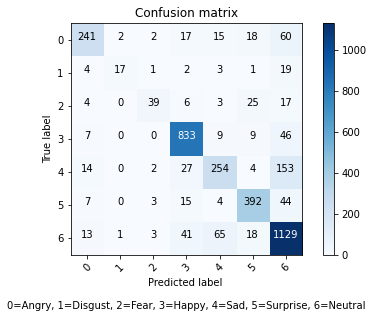

In [139]:
# Predict the values from the validation dataset
y_pred = save_model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))


In [140]:
score, acc = save_model.evaluate(X_test, y_test, verbose=0)
print('Test score: %.3f'% score)
print('Test accuracry: %.3f' % (acc * 100.0))

Test score: 0.677
Test accuracry: 79.298


rands: [1758, 2531, 2360, 1435, 262, 3438, 532]


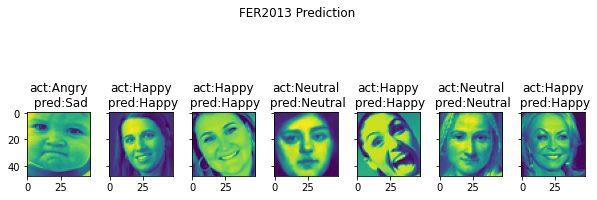

In [141]:
# Predict
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#random.seed(25)
rands = random.sample(range(0, 3588), 7)
print('rands:', rands)

# Plot
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, sharex=True,sharey=True,figsize=(10, 4))
axs=(ax1, ax2, ax3, ax4, ax5, ax6, ax7)
plt.subplots_adjust(wspace=0.3)
fig.suptitle('FER2013 Prediction')

for i, index in enumerate(rands):
  # predict
  x = np.array([X_test[index]])
  pred_x = np.argmax(save_model.predict(x))

  axs[i].imshow(X_test[index][:,:,0])
  e_id = np.argmax(y_test[index])              
  axs[i].set_title('act:{}\n pred:{}'.format(emotions[e_id], emotions[pred_x]) )

plt.show()